In [1]:
# This notebook is based on the very helpfull blog
# https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/
# more information:
# http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
def sitk_show(img, title=None, margin=0.05, dpi=40, scale=2, interpolation=None):
    # scale is a scaling factor for the shown image
    
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (scale + margin) * nda.shape[0] / dpi, (scale + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, scale - 2*margin, scale - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=interpolation)
    
    if title:
        plt.title(title)
    
    plt.show()

In [3]:
# Directory where the DICOM files are being stored (in this
# case the 'data/cropped_CT' folder). 
pathDicom = "../data/cropped_CT/"

# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelPlastic = 1
labelFilling = 2

In [4]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

In [5]:
# For now we'll only look at a single 2D image
# if we leave this out, the rest of the code will work with the 3D vomlume,
# so each time we'd like to visualize it, we'd have to choose one slice to be plotted:
# use imgOriginal[:,:,idxSlice] instead of imgOriginal_slice
imgOriginal_slice = imgOriginal[:,:,idxSlice]

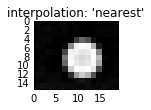

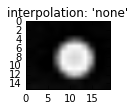

In [6]:
# and look at it
# if working with 3D volume: use imgOriginal[:,:,idxSlice] instead of imgOriginal_slice here
sitk_show(imgOriginal_slice, title="interpolation: 'nearest'", interpolation='nearest')
sitk_show(imgOriginal_slice, title="interpolation: 'none'")

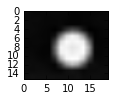

In [7]:
# denoise the image
# for denoising the whole volume we'd use imgOriginal instead of imgOriginal_slice
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal_slice,
                                    timeStep=0.125,
                                    numberOfIterations=5)

sitk_show(imgSmooth)

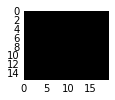

In [8]:
# for the filling I found a good pixel to be used as seed:
seedFilling = [(14,14)]
imgFilling = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=seedFilling, 
                                              lower=00, 
                                              upper=110,
                                              replaceValue=labelFilling)
sitk_show(imgFilling)

In [9]:
# for the plastic I'd like to get multiple seeds.
# -get maximum values of plastic for seedList-
# first make array out of denoised img:
arraySmooth = SimpleITK.GetArrayFromImage(imgSmooth)

# all pixels > 125 used as seeds:

maxPlastic = np.array(where(arraySmooth > 125)).T
print("maxPLastic: \n", maxPlastic)

# show seeds in array    
for x,y in maxPlastic:
    arraySmooth[x,y] = 1000
# plt.imshow(arraySmooth)

maxPLastic: 
 [[ 4  8]
 [ 5  7]
 [ 5  9]
 [ 6  6]
 [ 6 10]
 [ 7  7]
 [ 7  9]
 [ 7 10]
 [ 8  7]
 [ 8  8]
 [ 8  9]]


In [10]:
# make a list out of array:
seedPlastic = list(map(tuple, maxPlastic))
print("seedPlastic: \n type:", type(seedPlastic), "\n value:", seedPlastic)

seedPlastic: 
 type: <class 'list'> 
 value: [(4, 8), (5, 7), (5, 9), (6, 6), (6, 10), (7, 7), (7, 9), (7, 10), (8, 7), (8, 8), (8, 9)]


In [11]:
# now I'd like to use this list for the segmentation of the plastic

imgPlastic = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=seedPlastic, 
                                              lower=110, 
                                              upper=200,
                                              replaceValue=labelPlastic)

TypeError: in method 'ConnectedThreshold', argument 2 of type 'std::vector< std::vector< uint32_t,std::allocator< uint32_t > >,std::allocator< std::vector< uint32_t,std::allocator< uint32_t > > > > const &'

In [ ]:
# since this does not work, I try something similar to this proposed solution (for c++):
# http://public.kitware.com/pipermail/insight-users/2012-October/046193.html

# org.itk.simple.VectorUIntList seed = new
# org.itk.simple.VectorUIntList();
# org.itk.simple.VectorUInt32 pts;
# pts = new org.itk.simple.VectorUInt32(2);
# pts.push_back(128);
# pts.push_back(128);
# seed.push_back(pts);

seedPlastic1 = SimpleITK.VectorUIntList()
for pixel in seedPlastic:
    # for debugging purposes I want to see the type of pixel and seed
    print("pixel:\n type:", type(pixel), "\n value:", pixel,"\n")
    seed = SimpleITK.VectorUInt32(pixel)
    print("seed:\n type:", type(seed), "\n value:", seed)
    seedPlastic1.push_back(seed)

In [ ]:
# didn't work, but that's weird, because this works:

seedPlastic2 = SimpleITK.VectorUIntList()
pixel = (12,14)

seed = SimpleITK.VectorUInt32(pixel)

seedPlastic2.push_back(seed)

print("pixel:\n type:", type(pixel), "\n value:", pixel,"\n")
print("seed:\n type:", type(seed), "\n value:", seed)

# maybe this would lead to a solution(???):
# http://stackoverflow.com/questions/3761391/boostpython-python-list-to-stdvector
# http://stackoverflow.com/questions/4819707/passing-python-list-to-c-vector-using-boost-python